In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

2025-08-04 21:12:50.101891: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-04 21:12:50.135020: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-04 21:12:50.183919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754341970.236189    9541 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754341970.252011    9541 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754341970.322750    9541 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
data = pd.read_csv('../../dataset/redd_combined/house_1.csv')
data['mains'] = np.clip(data['mains'], 0, np.percentile(data['mains'], 99))  # Supprimer outliers
data['refrigerator'] = np.clip(data['refrigerator'], 0, np.percentile(data['refrigerator'], 99))



In [3]:
print(data.isna().sum())
print(data.head())

Timestamp          0
mains              0
bathroom_gfi       0
dishwaser          0
electric_heat      0
kitchen_outlets    0
lighting           0
microwave          0
oven               0
refrigerator       0
stove              0
washer_dryer       0
dtype: int64
    Timestamp   mains  bathroom_gfi  dishwaser  electric_heat  \
0  1303132929  342.82           1.0        0.0            0.0   
1  1303132930  344.56           1.0        0.0            0.0   
2  1303132931  345.14           1.0        0.0            0.0   
3  1303132932  341.68           1.0        0.0            0.0   
4  1303132933  341.03           1.0        0.0            0.0   

   kitchen_outlets  lighting  microwave  oven  refrigerator  stove  \
0             57.0     192.0        5.0   0.0           6.0    0.0   
1             57.0     192.0        5.0   0.0           6.0    0.0   
2             57.0     192.0        5.0   0.0           6.0    0.0   
3             57.0     192.0        5.0   0.0           6.0    0

In [4]:
#extract mains and fridge data
total_energy= data['mains'].values
fridge_energy= data['refrigerator'].values



In [5]:
# 2. Split par jours
# -----------------------------
samples_per_day = 24 * 3600
days_train, days_test = 3, 3

end_train = int(days_train * samples_per_day)
end_test = end_train + int(days_test * samples_per_day)

train_total_energy = total_energy[:end_train]
train_fridge_energy = fridge_energy[:end_train]
test_total_energy = total_energy[end_train:end_test]
test_fridge_energy = fridge_energy[end_train:end_test]

In [6]:
# 3. Normalisation
# -----------------------------
scaler_total = StandardScaler()
scaler_fridge = StandardScaler()

train_total_energy = scaler_total.fit_transform(train_total_energy.reshape(-1, 1)).flatten()
test_total_energy = scaler_total.transform(test_total_energy.reshape(-1, 1)).flatten()
train_fridge_energy = scaler_fridge.fit_transform(train_fridge_energy.reshape(-1, 1)).flatten()
test_fridge_energy = scaler_fridge.transform(test_fridge_energy.reshape(-1, 1)).flatten()

In [7]:
# 4. Séquençage plus simple (fenêtre glissante)
# -----------------------------
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

seq_length = 60  # plus grand = plus de contexte

X_train, y_train = create_sequences(train_total_energy, train_fridge_energy, seq_length)
X_test, y_test = create_sequences(test_total_energy, test_fridge_energy, seq_length)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [8]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.3),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# -----------------------------
# 6. Callbacks intelligents
# -----------------------------
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)
]

# -----------------------------
# 7. Entraînement
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=512,
    callbacks=callbacks,
    verbose=1
)


2025-08-04 21:13:01.427288: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/opt/conda/envs/nilmtk-env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 111s 235ms/step - loss: 0.5554 - mae: 0.4813 - val_loss: 0.3875 - val_mae: 0.2862 - learning_rate: 0.0010
Epoch 2/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 108s 237ms/step - loss: 0.3891 - mae: 0.3410 - val_loss: 0.3787 - val_mae: 0.2699 - learning_rate: 0.0010
Epoch 3/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 107s 235ms/step - loss: 0.3735 - mae: 0.3271 - val_loss: 0.3500 - val_mae: 0.2495 - learning_rate: 0.0010
Epoch 4/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 112s 246ms/step - loss: 0.3804 - mae: 0.3328 - val_loss: 0.3295 - val_mae: 0.2410 - learning_rate: 0.0010
Epoch 5/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 115s 251ms/step - loss: 0.3533 - mae: 0.3091 - val_loss: 0.3286 - val_mae: 0.2431 - learning_rate: 0.0010
Epoch 6/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 119s 261ms/step - loss: 0.3174 - mae: 0.2794 - val_loss: 0.3093 - val_mae: 0.2211 - learning_rate: 0.0010
Epoch 7/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 117s 257ms/step - loss: 0.2952 - mae: 0.2594 - val_loss: 0.3087 - val_mae: 0.2198 - 

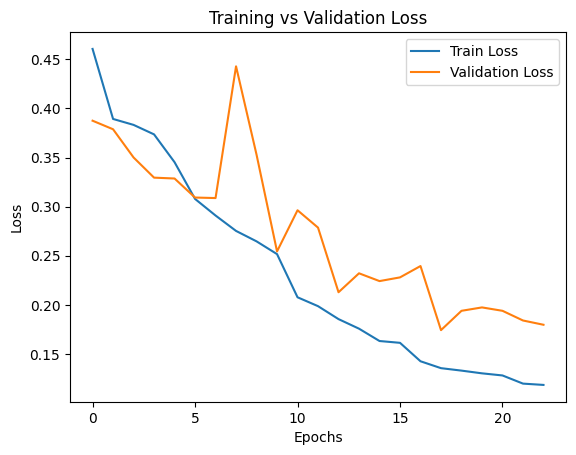

In [12]:
# Courbes de perte (loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [10]:
# 8. Prédictions et inverse transform
# -----------------------------
y_pred = model.predict(X_test, batch_size=512)
y_pred = np.clip(y_pred, 0, None)
y_pred = scaler_fridge.inverse_transform(y_pred)
y_true = scaler_fridge.inverse_transform(y_test.reshape(-1, 1))


507/507 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step


MSE  : 3406.05 W²
RMSE : 58.36 W
MAE  : 48.36 W
MAPE : 603.48 %
R²   : 0.4706


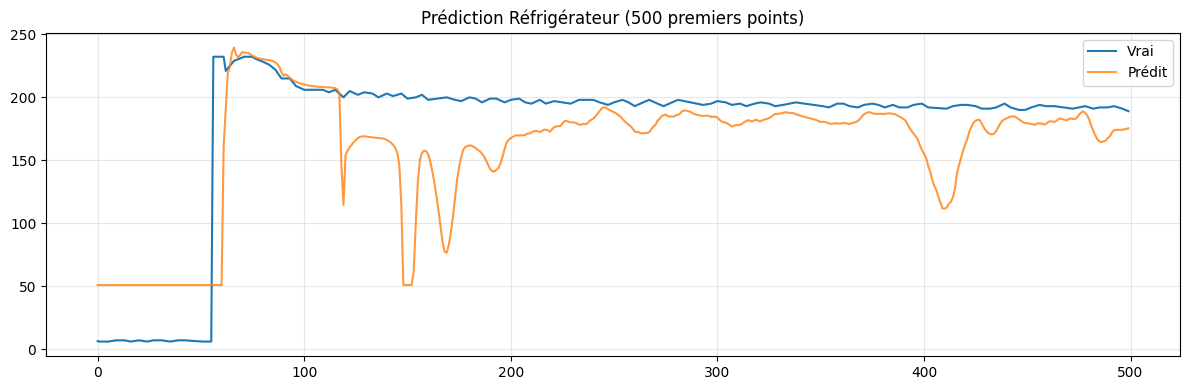

In [13]:
# 9. Évaluation
# -----------------------------
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100


print(f"MSE  : {mse:.2f} W²")
print(f"RMSE : {rmse:.2f} W")
print(f"MAE  : {mae:.2f} W")
print(f"MAPE : {mape:.2f} %")
print(f"R²   : {r2:.4f}")

# -----------------------------
# 10. Visualisation
# -----------------------------
plt.figure(figsize=(12, 4))
plt.plot(y_true[:500], label='Vrai')
plt.plot(y_pred[:500], label='Prédit', alpha=0.8)
plt.legend()
plt.title("Prédiction Réfrigérateur (500 premiers points)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

